In [1]:
!pip install torch torchvision torchaudio
!pip install transformers
!pip install -q transformers datasets
!pip install timm
!pip install transformers datasets torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import faster_rcnn
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pycocotools.coco import COCO

In [8]:
# Paths to the COCO format dataset
train_path = '/content/drive/MyDrive/Helmet_Detection.v1i.coco/train'
val_path = '/content/drive/MyDrive/Helmet_Detection.v1i.coco/valid'
train_annotation = '/content/drive/MyDrive/Helmet_Detection.v1i.coco/_trainannotations.coco.json'
val_annotation = '/content/drive/MyDrive/Helmet_Detection.v1i.coco/_validannotations.coco.json'

In [9]:
# Define the transformations and dataset loading
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to [0, 1] range and rearranges to CxHxW
    transforms.Resize((224, 224)),  # Resize for the model expected input dimensions
])

train_dataset = CocoDetection(root=train_path,
                              annFile=train_annotation,
                              transform=transform)
val_dataset = CocoDetection(root=val_path,
                            annFile=val_annotation,
                            transform=transform)


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [10]:
# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224', do_resize=False, do_normalize=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
# Collate function to handle the batches
def collate_fn(batch):
    pixel_values = torch.stack([feature_extractor(images=item[0], return_tensors='pt')['pixel_values'].squeeze(0) for item in batch])
    labels = [torch.tensor([ann['category_id'] for ann in item[1]], dtype=torch.int64) for item in batch]  # Processing category ids
    return pixel_values, labels

In [12]:
# Data loaders with the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

In [13]:
# Load the model with the correct number of classes
num_classes = len(train_dataset.coco.getCatIds())
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 2
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 2
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, l

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 0.6522, Accuracy: 0.5050, Precision: 0.3369, Recall: 0.3361, F1-Score: 0.3364
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping ba

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12, Loss: 0.6067, Accuracy: 0.5185, Precision: 0.3469, Recall: 0.3466, F1-Score: 0.3454
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 1
Skipping b

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 2
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 3
Skipping batch due to size mismatch: inputs 4, labels 2
Skipping batch due to size mismatch: inputs 4, l

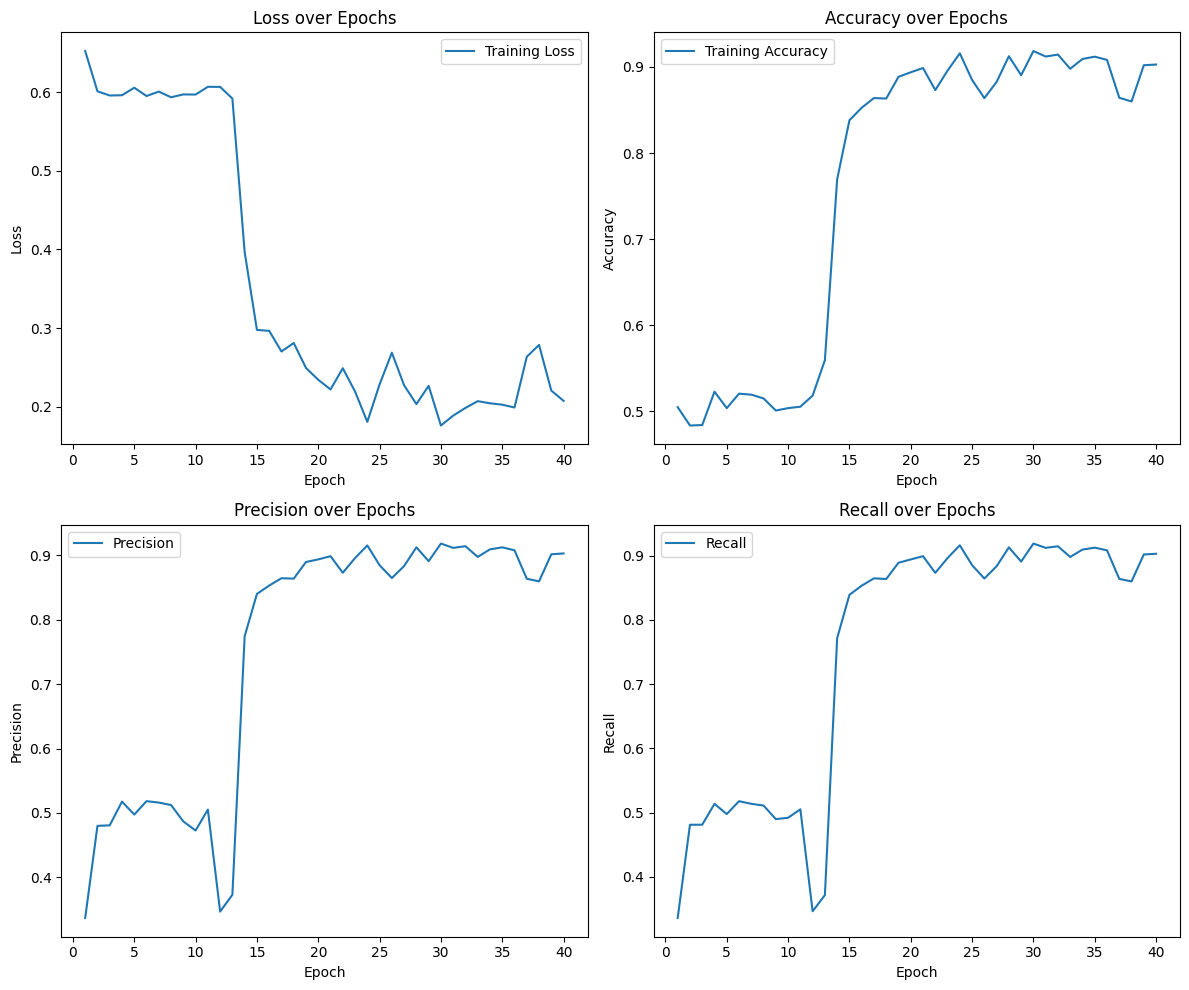

In [15]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
epoch_accuracies = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []

# Define checkpoint path
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop
model.train()
for epoch in range(40):  # Adjust to the desired number of epochs
    total_loss = 0
    all_predictions = []
    all_labels = []

    for pixel_values, labels in train_dataloader:
        pixel_values = pixel_values.to(device)

        # Adjust labels to ensure they match the batch size of inputs
        adjusted_labels = torch.tensor([label[0] - 1 for label in labels if len(label) > 0], dtype=torch.long)
        adjusted_labels = adjusted_labels.to(device)

        # Ensure batch sizes match
        if pixel_values.size(0) != adjusted_labels.size(0):
            print(f"Skipping batch due to size mismatch: inputs {pixel_values.size(0)}, labels {adjusted_labels.size(0)}")
            continue

        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values, labels=adjusted_labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(adjusted_labels.cpu().numpy())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_f1s.append(f1)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
        }, checkpoint_path)

# Plotting metrics
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, 41), epoch_losses, label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(1, 41), epoch_accuracies, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(1, 41), epoch_precisions, label='Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(1, 41), epoch_recalls, label='Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
print("Pixel values device and dtype:", pixel_values.device, pixel_values.dtype)
print("Labels device and dtype:", adjusted_labels.device, adjusted_labels.dtype)
print("Model device:", next(model.parameters()).device)

Pixel values device and dtype: cuda:0 torch.float32
Labels device and dtype: cuda:0 torch.int64
Model device: cuda:0


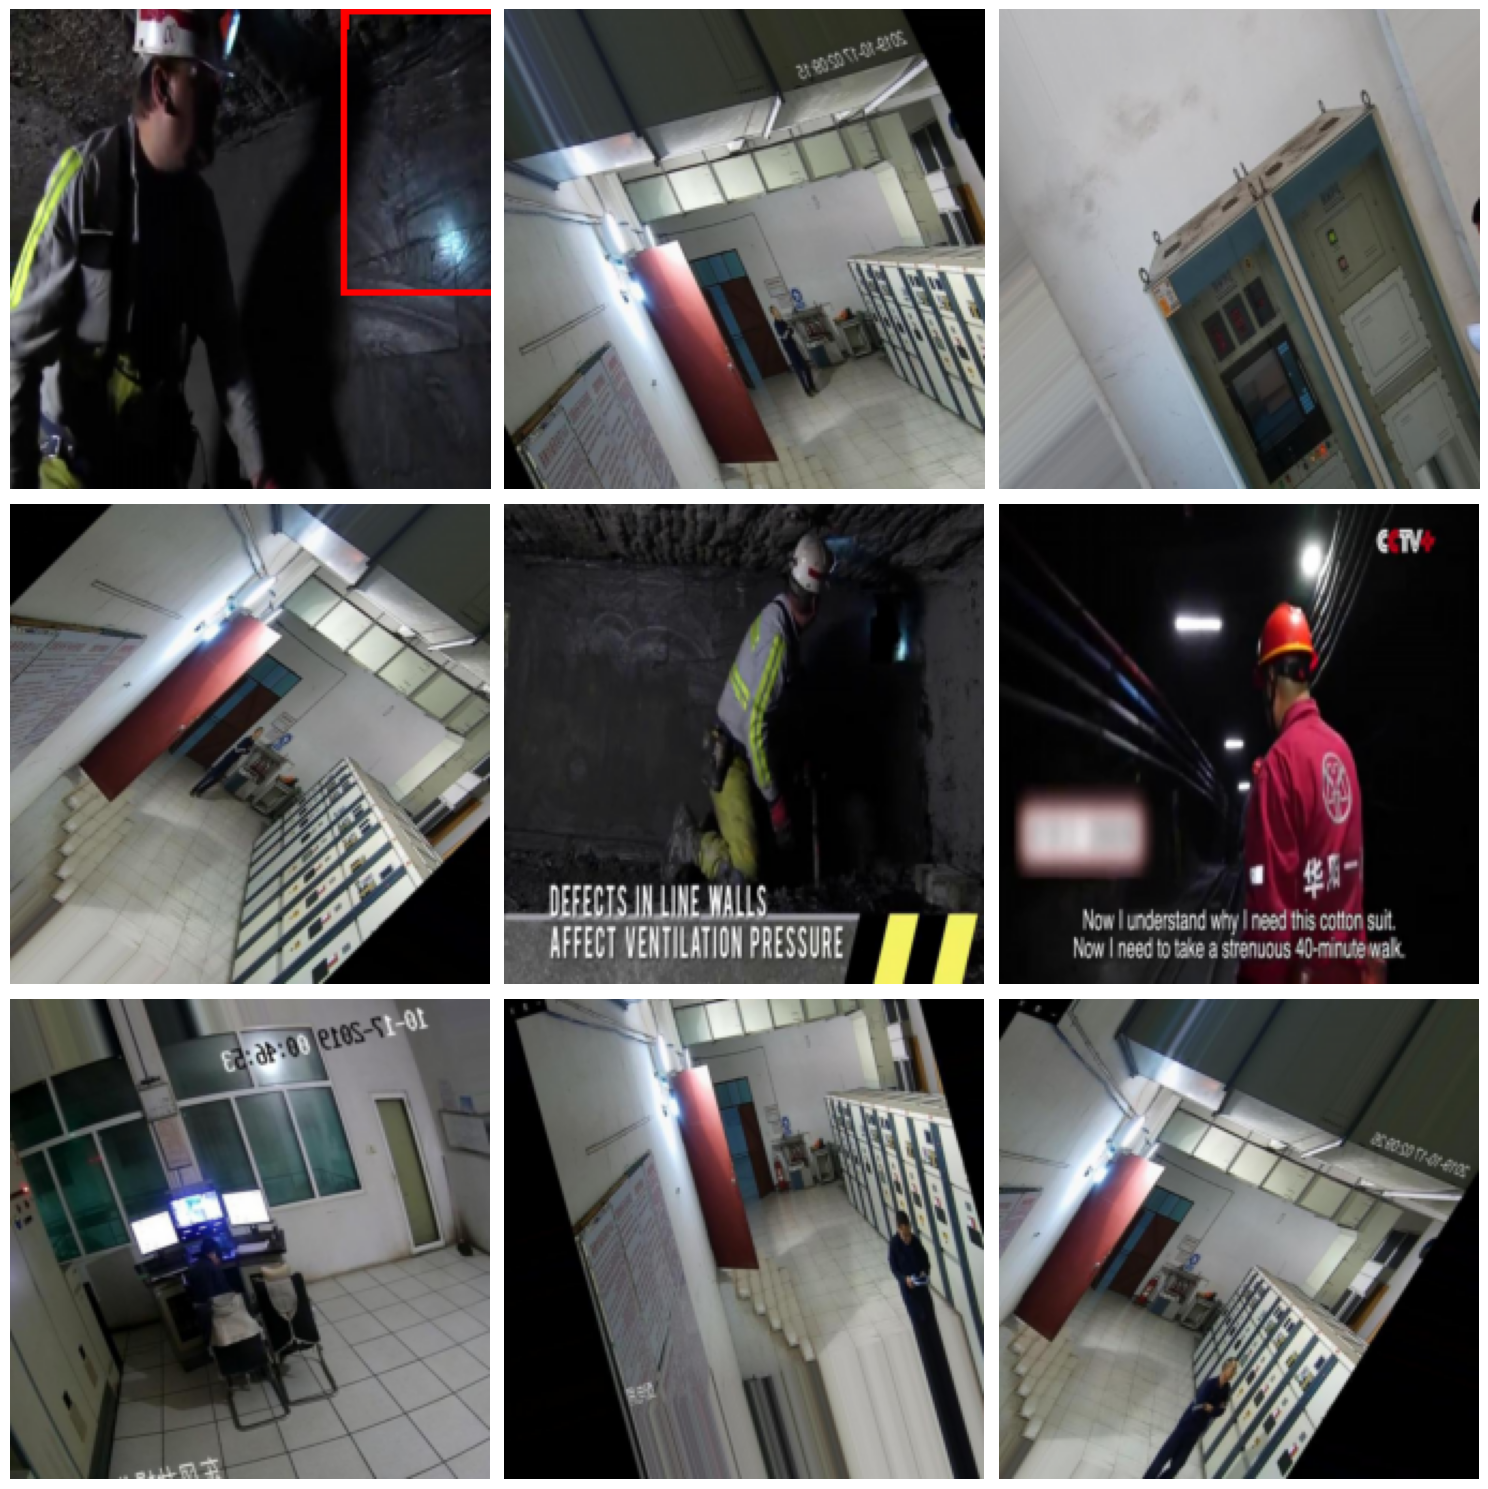

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import torchvision.transforms.functional as F

def draw_image_from_idx(dataset, idx):
    """
    Draw an image with annotations from the dataset.
    """
    img, target = dataset[idx]
    img = F.to_pil_image(img)  # Convert the tensor image to a PIL image for display

    # Create a drawing context
    draw = ImageDraw.Draw(img)

    for elem in target:
        # COCO bbox format: [top left x, top left y, width, height]
        box = elem['bbox']
        # Draw rectangle on image
        draw.rectangle([
            (box[0], box[1]),             # Top left corner
            (box[0] + box[2], box[1] + box[3])  # Bottom right corner
        ], outline="red", width=3)

        # Optionally add text label to the boxes
        category_id = elem['category_id']
        draw.text((box[0], box[1]), str(category_id), fill="red")

    return img

def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3 + (1 if len(indices) % 3 > 0 else 0)
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten() if num_rows > 1 else axes

    for i, idx in enumerate(indices):
        image = draw_image_from_idx(dataset, idx)
        axes[i].imshow(image)
        axes[i].axis("off")

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example of how to use the function to plot images
plot_images(train_dataset, range(9))


In [20]:
def draw_image_from_idx(dataset, idx, model, device):
    img, target = dataset[idx]
    img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension and move to device

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)

    # Print or log the structure of outputs to understand what it contains
    print(outputs)

    # If outputs contain the expected keys, continue processing (otherwise adjust accordingly)
    if 'boxes' in outputs and 'scores' in outputs and 'labels' in outputs:
        img = F.to_pil_image(img)  # Convert the tensor image to a PIL image for display
        draw = ImageDraw.Draw(img)
        for box, score, label in zip(outputs['boxes'], outputs['scores'], outputs['labels']):
            if score > 0.5:  # Consider only detections with confidence score above a threshold
                box = box.cpu().numpy()
                draw.rectangle([(box[0], box[1]), (box[0] + box[2], box[1] + box[3])], outline="red", width=3)
                draw.text((box[0], box[1]), f'{label} ({score:.2f})', fill="red")
        return img
    else:
        raise ValueError("Model output does not contain 'boxes', 'scores', or 'labels'")


In [21]:
import os

results_dir = "model_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


In [22]:
import os
import torch

results_dir = "model_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save the model's weights
torch.save(model.state_dict(), os.path.join(results_dir, 'model_weights.pth'))


In [23]:
# Load the model's weights
model.load_state_dict(torch.load(os.path.join(results_dir, 'model_weights.pth')))


<ipython-input-23-635327d9b78e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(results_dir, 'model_weights.pth')))


<All keys matched successfully>

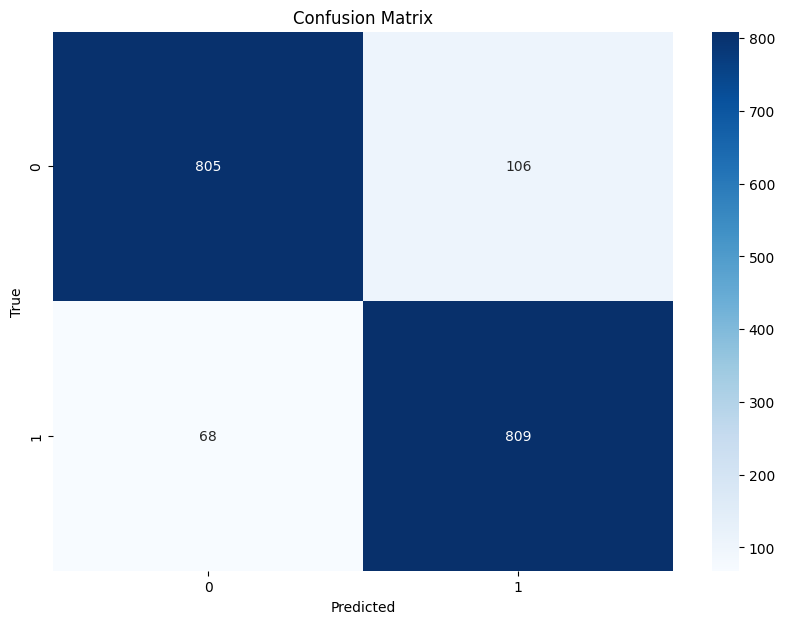

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

results_dir = "model_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_df = pd.DataFrame(cm)

# Save as CSV
cm_df.to_csv(os.path.join(results_dir, 'confusion_matrix.csv'))

# Plot and save as an image
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))

plt.show()


In [25]:
import pandas as pd
import os

# Assuming you have metrics stored in lists or arrays
epoch_losses = [0.2, 0.15, 0.1]  # Example data
epoch_accuracies = [0.85, 0.9, 0.92]  # Example data
epoch_precisions = [0.8, 0.85, 0.88]  # Example data
epoch_recalls = [0.75, 0.8, 0.85]  # Example data
epoch_f1s = [0.77, 0.82, 0.86]  # Example data

# Create a DataFrame with your metrics
results_df = pd.DataFrame({
    'Epoch': range(1, len(epoch_losses) + 1),
    'Loss': epoch_losses,
    'Accuracy': epoch_accuracies,
    'Precision': epoch_precisions,
    'Recall': epoch_recalls,
    'F1-Score': epoch_f1s
})

# Ensure the results directory exists
results_dir = "model_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save the DataFrame to an Excel file
results_df.to_excel(os.path.join(results_dir, 'results.xlsx'), index=False)

print("Results saved to 'results.xlsx'")


Results saved to 'results.xlsx'


In [26]:
import shutil

shutil.make_archive(results_dir, 'zip', results_dir)

'/content/model_results.zip'

In [27]:
import os
import zipfile

# Define the results directory and the name of the ZIP file
results_dir = "model_results"
zip_filename = "results.zip"

# Save the confusion matrix CSV file and the confusion matrix image
results_df.to_excel(os.path.join(results_dir, 'results.xlsx'), index=False)
cm_df.to_csv(os.path.join(results_dir, 'confusion_matrix.csv'))
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))

# Create a ZIP file and add the results files to it
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(results_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), results_dir))

print(f"Results have been zipped into '{zip_filename}'")


Results have been zipped into 'results.zip'


<Figure size 640x480 with 0 Axes>

In [28]:
import os
print(os.getcwd())


/content


In [29]:
from google.colab import files
files.download('model_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>